
---

```markdown
# Завдання проєкту: Класифікація текстів (Sentiment Analysis)

## Мета
Розробити та порівняти кілька моделей класифікації текстів за тональністю.  
Дослідити, як попередня обробка даних, гіперпараметри та архітектура моделі впливають на точність.

---

## Дані
- Вхідні дані: тексти та відповідні мітки тональності (`negative`, `neutral`, `positive`).  
- Розподіл на спліти:
  - Train: 21,985 прикладів  
  - Validation: 5,496 прикладів  
  - Test: 3,534 приклади (без міток, використовується для сабмішну)  

---

## Етапи роботи

### 1. Попередня обробка
- Перевірка та нормалізація текстів (лематизація, видалення стоп-слів).  
- Для BERT від нормалізації відмовились, оскільки вона знижувала якість: модель втрачала контекст.  

### 2. Базова модель: Логістична регресія
- Використано Bag-of-Words / TF-IDF ознаки.  
- Результат: дуже низька точність на валідації.  
- Висновок: модель не змогла якісно врахувати контекст, проте як «baseline» була корисною.  

### 3. Модель BERT (DistilBERT)
- Використано `distilbert-base-uncased` з HuggingFace Transformers.  
- Токенізація: `max_length=256` (також експерименти з 384 та 512).  
- Використано `Trainer` з параметрами:
  - Batch size: 32 (підбір розміру мав найбільший вплив на точність).
  - Learning rate: 2e-5 → експерименти з 1e-5.
  - Epochs: 10–15 з EarlyStopping.  
- Метрика: Accuracy + F1.  

### 4. Баланс класів
- Перевірено дисбаланс у train.  
- Реалізовано варіант з **class weights** через кастомний `WeightedLossTrainer`.  

---

## Результати
- **Логістична регресія**: дуже низькі результати (baseline).  
- **DistilBERT**: ~0.79 accuracy на валідації.  
- Найкращі результати дали:
  - Відмова від нормалізації текстів.  
  - Підібраний розмір batch.  
  - EarlyStopping для запобігання оверфіту.  

---

## Висновки
- Простих моделей (логістична регресія) недостатньо для задачі, де важливий контекст.  
- BERT вимагає більше ресурсів, але показує суттєво кращу якість.  
- Головні фактори впливу:
  - Розмір batch.
  - Використання/невикористання нормалізації.
  - Гіперпараметри оптимізатора.  
- Модель готова для сабмішну, використано чекпоінт з найкращою валідаційною точністю.

---

## Наступні кроки
- Спробувати інші архітектури (`bert-base`, `roberta-base`).  
- Збільшити `max_length`, якщо тексти довші.  
- Дослідити data augmentation для покращення узагальнення.  
```

---

In [1]:
#! pip install tensorflow

In [2]:
#! pip install transformers

In [3]:
#! pip install nltk

In [4]:
#! pip install spacy

In [5]:
#! pip install seaborn

In [6]:
import re
import os
import string
import itertools
from collections import Counter

import pandas as pd
import numpy as np

from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem.porter import PorterStemmer

import spacy

from tqdm.auto import tqdm
tqdm.pandas()

import matplotlib.pyplot as plt

from sklearn.metrics import accuracy_score

from sklearn.model_selection import train_test_split
from datasets import Dataset, DatasetDict
from transformers import (AutoTokenizer, AutoModelForSequenceClassification,
                          DataCollatorWithPadding, TrainingArguments, Trainer)
import evaluate
import torch
#from tensorflow.keras.models import Sequential
#from tensorflow.keras.layers import Embedding, LSTM, Dense
#from tensorflow.keras.preprocessing.text import Tokenizer
import torch
from sklearn.linear_model import LogisticRegression, RidgeClassifier, SGDClassifier
from sklearn.svm import LinearSVC
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from transformers import AutoTokenizer, AutoModelForSequenceClassification

import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     /teamspace/studios/this_studio/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [7]:
DATA_DIR = "./test-task-for-ds-nlp-2025-mds-6"

train_path = os.path.join(DATA_DIR, "train.csv")
test_path  = os.path.join(DATA_DIR, "test.csv")
sample_sub = os.path.join(DATA_DIR, "sample_submission.csv")

train = pd.read_csv(train_path)
test  = pd.read_csv(test_path)
sample = pd.read_csv(sample_sub)

print("Train shape:", train.shape)
display(train.head())
print("Test  shape:", test.shape)
display(test.head())
print("Sample head:")
display(sample.head())

Train shape: (27481, 3)


,ID,text,sentiment
0,cb774db0d1,"I`d have responded, if I were going",neutral
1,549e992a42,Sooo SAD I will miss you here in San Diego!!!,negative
2,088c60f138,my boss is bullying me...,negative
3,9642c003ef,what interview! leave me alone,negative
4,358bd9e861,"Sons of ****, why couldn`t they put them on t...",negative


Test  shape: (3534, 2)


,ID,text
0,f87dea47db,Last session of the day http://twitpic.com/67ezh
1,96d74cb729,Shanghai is also really exciting (precisely -...
2,eee518ae67,"Recession hit Veronique Branquinho, she has to..."
3,01082688c6,happy bday!
4,33987a8ee5,http://twitpic.com/4w75p - I like it!!


Sample head:


,ID,sentiment
0,df9123ga1l,neutral
1,sa41adl13d,positive
2,13adskb1da7,negative


In [8]:
# Dataset preview

train.head(3)

,ID,text,sentiment
0,cb774db0d1,"I`d have responded, if I were going",neutral
1,549e992a42,Sooo SAD I will miss you here in San Diego!!!,negative
2,088c60f138,my boss is bullying me...,negative


In [9]:
# Basic dataset info 

train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27481 entries, 0 to 27480
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   ID         27481 non-null  object
 1   text       27480 non-null  object
 2   sentiment  27481 non-null  object
dtypes: object(3)
memory usage: 644.2+ KB


In [10]:
train['sentiment_num'] = train['sentiment'].map({
    'positive' : 2,
    'neutral' : 1,
    'negative' : 0
})

In [11]:
neutral_idx = train.index[train["sentiment_num"] == 1].tolist()
np.random.seed(42)
remove_idx = np.random.choice(neutral_idx, size=2500, replace=False)

train = train.drop(remove_idx)

In [12]:
train.head()

,ID,text,sentiment,sentiment_num
1,549e992a42,Sooo SAD I will miss you here in San Diego!!!,negative,0
2,088c60f138,my boss is bullying me...,negative,0
3,9642c003ef,what interview! leave me alone,negative,0
4,358bd9e861,"Sons of ****, why couldn`t they put them on t...",negative,0
5,28b57f3990,http://www.dothebouncy.com/smf - some shameles...,neutral,1


In [13]:
# Number of identical records

train.duplicated().sum()

0

In [14]:
# Contractions. Source http://stackoverflow.com/questions/19790188/expanding-english-language-contractions-in-python

contractions = { 
"ain't": "am not",
"aren't": "are not",
"can't": "cannot",
"can't've": "cannot have",
"'cause": "because",
"could've": "could have",
"couldn't": "could not",
"couldn't've": "could not have",
"didn't": "did not",
"doesn't": "does not",
"don't": "do not",
"hadn't": "had not",
"hadn't've": "had not have",
"hasn't": "has not",
"haven't": "have not",
"he'd": "he would",
"he'd've": "he would have",
"he'll": "he will",
"he's": "he is",
"how'd": "how did",
"how'll": "how will",
"how's": "how is",
"i'd": "i would",
"i'll": "i will",
"i'm": "i am",
"i've": "i have",
"isn't": "is not",
"it'd": "it would",
"it'll": "it will",
"it's": "it is",
"let's": "let us",
"ma'am": "madam",
"mayn't": "may not",
"might've": "might have",
"mightn't": "might not",
"must've": "must have",
"mustn't": "must not",
"needn't": "need not",
"oughtn't": "ought not",
"shan't": "shall not",
"sha'n't": "shall not",
"she'd": "she would",
"she'll": "she will",
"she's": "she is",
"should've": "should have",
"shouldn't": "should not",
"that'd": "that would",
"that's": "that is",
"there'd": "there had",
"there's": "there is",
"they'd": "they would",
"they'll": "they will",
"they're": "they are",
"they've": "they have",
"wasn't": "was not",
"we'd": "we would",
"we'll": "we will",
"we're": "we are",
"we've": "we have",
"weren't": "were not",
"what'll": "what will",
"what're": "what are",
"what's": "what is",
"what've": "what have",
"where'd": "where did",
"where's": "where is",
"who'll": "who will",
"who's": "who is",
"won't": "will not",
"wouldn't": "would not",
"you'd": "you would",
"you'll": "you will",
"you're": "you are"
}

In [15]:
# get stop-words from the nltk library
# using set to make words search faster

stop_words = set(stopwords.words('english')).union({'also', 'would', 'much', 'many'})
print(stop_words)

{'mightn', 'theirs', 'whom', 'weren', 'will', "wasn't", 'ours', "aren't", 'once', 'won', 'this', 'further', 'had', 'again', "i'd", 'who', 'ourselves', 'd', 'wasn', 'you', 'such', "shouldn't", 've', 'being', 'did', "weren't", 'which', 'only', 'over', "we'd", 'while', "you're", 'above', 'more', 'your', 'where', "should've", 'so', 'own', 'them', 'have', "hasn't", "we've", 'by', 'didn', 'they', 'to', 'doing', "wouldn't", 'him', "they've", 'much', 'very', "it's", 'same', 'been', "you've", 'himself', 'on', 'do', "doesn't", 'from', 'were', 'm', 'about', 'before', "she'd", 'she', 'yours', 'doesn', 'don', "needn't", 'itself', "shan't", 'and', 'under', 'a', "he's", 'me', 'how', "you'll", 'both', 'has', 'at', "she's", 'am', 'can', 'what', "he'll", 'hadn', 'does', "that'll", 'haven', 'other', 'why', 'their', 'his', 'but', 'nor', "won't", 'yourselves', "didn't", "mightn't", 'many', 'into', 'mustn', 'in', 'some', 'through', 'ma', 'just', 'our', 'needn', 'here', 'i', 'between', "couldn't", 'he', 'unt

In [16]:
negations = {
    'aren',
    "aren't",
    'couldn',
    "couldn't",
    'didn',
    "didn't",
    'doesn',
    "doesn't",
    'don',
    "don't",
    'hadn',
    "hadn't",
    'hasn',
    "hasn't",
    'haven',
    "haven't",
    'isn',
    "isn't",
    'mightn',
    "mightn't",
    'mustn',
    "mustn't",
    'needn',
    "needn't",
    'no',
    'nor',
    'not',
    'shan',
    "shan't",
    'shouldn',
    "shouldn't",
    'wasn',
    "wasn't",
    'weren',
    "weren't",
    'won',
    "won't",
    'wouldn',
    "wouldn't"
}

In [17]:
# removing negations from the stop-words list

stop_words = stop_words.difference(negations)

In [18]:
stemmer = PorterStemmer()

In [19]:
! python3 -m spacy download en_core_web_sm

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.8/12.8 MB 196.0 MB/s  0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')


In [20]:
nlp = spacy.load("en_core_web_sm", disable = ['parser','ner'])

In [21]:
# function to clean text
def normalize_text(raw_review):
    
    # Remove html tags
    text = re.sub(r"<[^>]*>", " ", raw_review) # match <> and everything in between. [^>] - match everything except >
    
    # Remove emails
    text = re.sub(r"\S*@\S*[\s]+", " ", text) # match non-whitespace characters, @ and a whitespaces in the end
    
    # remove links
    text = re.sub(r"https?:\/\/.*?[\s]+", " ", text) # match http, s - zero or once, //, 
                                                    # any char 0-unlimited, whitespaces in the end
        
     # Convert to lower case, split into individual words
    text = text.lower().split()
    
    # Replace contractions with their full versions
    text = [contractions.get(word) if word in contractions else word 
            for word in text]
   
    # Re-splitting for the correct stop-words extraction
    text = " ".join(text).split()    
    
    # Remove stop words
    text = [word for word in text if not word in stop_words]

    text = " ".join(text)
    
    # Remove non-letters        
    text = re.sub(r"[^a-zA-Z' ]", "", text) # match everything except letters and '


    # Stem words. Need to define porter stemmer above
    # text = [stemmer.stem(word) for word in text.split()]

    # Lemmatize words. Need to define lemmatizer above
    doc = nlp(text)
    text = " ".join([token.lemma_ for token in doc if len(token.lemma_) > 1 ])
    
    # Remove excesive whitespaces
    text = re.sub(r"[\s]+", " ", text)    
    
    # Join the words back into one string separated by space, and return the result.
    return text

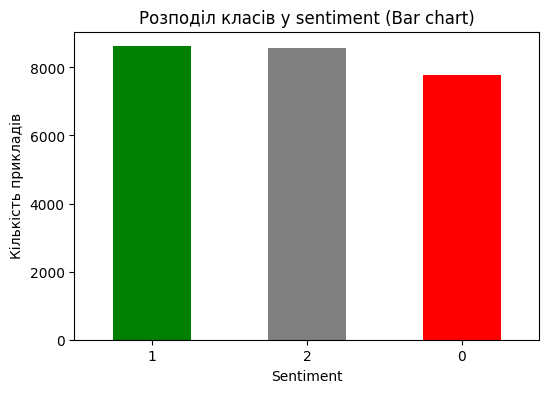

In [22]:
# Рахуємо кількість кожного класу
counts = train['sentiment_num'].value_counts()

# Малюємо bar chart
plt.figure(figsize=(6,4))
counts.plot(kind='bar', color=['green','gray','red'])
plt.title("Розподіл класів у sentiment (Bar chart)")
plt.xlabel("Sentiment")
plt.ylabel("Кількість прикладів")
plt.xticks(rotation=0)
plt.show()

In [23]:
train["text"] = train["text"].fillna("")

#train['text'] = train['text'].progress_apply(normalize_text)

In [24]:
train.head()

,ID,text,sentiment,sentiment_num
1,549e992a42,Sooo SAD I will miss you here in San Diego!!!,negative,0
2,088c60f138,my boss is bullying me...,negative,0
3,9642c003ef,what interview! leave me alone,negative,0
4,358bd9e861,"Sons of ****, why couldn`t they put them on t...",negative,0
5,28b57f3990,http://www.dothebouncy.com/smf - some shameles...,neutral,1


In [25]:
train_idxs = train.sample(frac=0.8, random_state=42).index
val_idxs = [idx for idx in train.index if idx not in train_idxs]

In [26]:
X_train = train.loc[train_idxs, 'text']
X_test = train.loc[val_idxs, 'text']

y_train = train.loc[train_idxs, 'sentiment_num']
y_test = train.loc[val_idxs, 'sentiment_num']

In [27]:
# Creating and training a CountVectorizer object 

#vect = CountVectorizer().fit(X_train)

#len(vect.vocabulary_)

In [28]:
# features examples

#vect.get_feature_names_out()[:5]

In [29]:
# transform the documents in the training data to a document-term matrix

#X_train_vectorized = vect.transform(X_train)
#X_train_vectorized.shape

In [30]:
# Resulted features representation is a sparse matrix

#X_train_vectorized

In [31]:
# model = LogisticRegression(
#     solver="lbfgs",
#     max_iter=1000,        # было 100
#     random_state=42)
# model.fit(X_train_vectorized, y_train)

In [32]:
# predictions = model.predict(vect.transform(X_test))

# print("Accuracy:", accuracy_score(y_test, predictions))

In [33]:
# Xte = vect.transform(test["text"].fillna(""))   # обязательно fillna("")
# y_pred = model.predict(Xte)

# # 3. Упаковываем в DataFrame для сабмита
# submission = pd.DataFrame({
#     "ID": test["ID"],
#     "sentiment": y_pred
# })
# submission['sentiment'] = submission['sentiment'].map({
#     0 : 'negative',
#     2 : 'positive',
#     1 : 'neutral'
# })


# # 4. Сохраняем в CSV
# submission.to_csv("submission.csv", index=False)
# print("Файл submission.csv успешно сохранён!")

In [34]:
#submission.head()

In [35]:
#import torch
print(torch.cuda.is_available()) 
device = "cuda" if torch.cuda.is_available() else None

True


In [36]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3534 entries, 0 to 3533
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   ID      3534 non-null   object
 1   text    3534 non-null   object
dtypes: object(2)
memory usage: 55.3+ KB


In [37]:
test["ID"] = test["ID"].astype(str)
test["text"] = test["text"].fillna("").astype(str)


print(test.dtypes)


ID      object
text    object
dtype: object


In [38]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3534 entries, 0 to 3533
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   ID      3534 non-null   object
 1   text    3534 non-null   object
dtypes: object(2)
memory usage: 55.3+ KB


In [39]:
test.dtypes

ID      object
text    object
dtype: object

In [40]:

ds = DatasetDict({
    "train": Dataset.from_dict({
        "text": X_train, 
        "labels": y_train
    }),
    "validation": Dataset.from_dict({
        "text": X_test, 
        "labels": y_test
    }),
    "test": Dataset.from_pandas(test)  # Pass the prepared DataFrame
})
print(ds)

DatasetDict({
    train: Dataset({
        features: ['text', 'labels'],
        num_rows: 19985
    })
    validation: Dataset({
        features: ['text', 'labels'],
        num_rows: 4996
    })
    test: Dataset({
        features: ['ID', 'text'],
        num_rows: 3534
    })
})


In [41]:
ds

DatasetDict({
    train: Dataset({
        features: ['text', 'labels'],
        num_rows: 19985
    })
    validation: Dataset({
        features: ['text', 'labels'],
        num_rows: 4996
    })
    test: Dataset({
        features: ['ID', 'text'],
        num_rows: 3534
    })
})

In [42]:
test.dtypes

ID      object
text    object
dtype: object

In [43]:

model_name = "roberta-base" #"distilbert-base-uncased" "bert-base-uncased" # 
tokenizer = AutoTokenizer.from_pretrained(model_name)

def tok_fn(batch):
    return tokenizer(batch["text"], truncation=True, max_length=256)

for split in ["train", "validation"]:
    ds[split] = ds[split].map(
        tok_fn, batched=True, remove_columns=["text"], desc=f"Tokenizing {split}"
    )
ds["test"] = ds["test"].map(
    tok_fn, batched=True, remove_columns=["text"], desc="Tokenizing test"
)
collator = DataCollatorWithPadding(tokenizer=tokenizer)

Tokenizing train:   0%|          | 0/19985 [00:00<?, ? examples/s]

Tokenizing validation:   0%|          | 0/4996 [00:00<?, ? examples/s]

Tokenizing test:   0%|          | 0/3534 [00:00<?, ? examples/s]

In [44]:
#  Модель -----
model = AutoModelForSequenceClassification.from_pretrained(
    model_name,
    num_labels=3 
)

# model.config.dropout = 0.1
# model.config.attention_dropout = 0.1
# if hasattr(model.config, "seq_classif_dropout"):
#     model.config.seq_classif_dropout = 0.1

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [45]:
# ----- 5)  (Accuracy) -----
metric = evaluate.load("accuracy")
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    preds = logits.argmax(axis=-1)
    return {"accuracy": metric.compute(references=labels, predictions=preds)["accuracy"]}

In [46]:
import transformers
print(transformers.__version__)

4.56.1


In [47]:
os.environ["TOKENIZERS_PARALLELISM"] = "false"

In [48]:
#!pip install 'accelerate>=0.26.0'

In [49]:
from transformers import TrainingArguments, Trainer
args = TrainingArguments(
    output_dir="bert_sa_ckpt",
    eval_strategy="epoch",
    save_strategy="epoch",
    learning_rate=1e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=5,
    warmup_ratio=0.1,
    weight_decay=0.01,
    #max_grad_norm=1.0, # +
    load_best_model_at_end=True,
    metric_for_best_model="accuracy",
    fp16=torch.cuda.is_available(),
    greater_is_better=True,
    report_to="none",
    seed=42,
)

In [50]:
# from transformers import TrainerCallback
# # For Losses visualization

# for cb in list(trainer.callback_handler.callbacks):
#     if cb.__class__.__name__ in {"HistoryRecorder", "TrainEvalCallback"}:
#         trainer.remove_callback(cb.__class__)
        
# class HistoryRecorder(TrainerCallback):
#     def __init__(self):
#         self.records = []

#     def on_epoch_end(self, args, state, control, **kwargs):
#         trainer = kwargs["trainer"]

#         val_metrics = trainer.evaluate(trainer.eval_dataset, metric_key_prefix="val")
#         train_metrics = trainer.evaluate(trainer.train_dataset, metric_key_prefix="train")

#         row = {
#             "epoch": state.epoch,
#             "train_loss": train_metrics.get("train_loss"),
#             "train_accuracy": train_metrics.get("train_accuracy"),
#             "val_loss": val_metrics.get("val_loss"),
#             "val_accuracy": val_metrics.get("val_accuracy"),
#         }
#         self.records.append(row)

#         pd.DataFrame(self.records).to_csv("history_epoch.csv", index=False)

# rec = HistoryRecorder()

In [51]:
# trainer = Trainer(
#     model=model,
#     args=args,
#     train_dataset=ds["train"],
#     eval_dataset=ds["validation"],
#     tokenizer=tokenizer,
#     data_collator=collator,
#     compute_metrics=compute_metrics,
#     callbacks=[rec],
# )

In [52]:
from collections import Counter
import torch.nn.functional as F
from transformers import Trainer

# 1) compute weights from training labels
labels = np.array(ds["train"]["labels"])
cnt = Counter(labels.tolist())
num_classes = len(set(labels))
total = len(labels)
class_weights = torch.tensor([total / (num_classes * cnt.get(i, 1)) for i in range(num_classes)],
                             dtype=torch.float)

# 2) custom Trainer that applies weighted CE
class WeightedLossTrainer(Trainer):
    def __init__(self, *args, class_weights=None, **kwargs):
        super().__init__(*args, **kwargs)
        self.class_weights = class_weights

    def compute_loss(self, model, inputs, return_outputs=False, **kwargs):
        labels = inputs.pop("labels")
        outputs = model(**inputs)
        logits = outputs.logits
        # CrossEntropyLoss 
        loss_fct = torch.nn.CrossEntropyLoss(
            weight=self.class_weights.to(logits.device) if self.class_weights is not None else None
        )
        loss = loss_fct(logits.view(-1, logits.size(-1)), labels.view(-1))
        return (loss, outputs) if return_outputs else loss

trainer = WeightedLossTrainer(
    model=model,
    args=args,  #  TrainingArguments
    train_dataset=ds["train"],
    eval_dataset=ds["validation"],
    tokenizer=tokenizer,
    data_collator=collator,
    compute_metrics=compute_metrics,
    class_weights=class_weights,
)

/tmp/ipykernel_271924/2317518402.py:16: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `WeightedLossTrainer.__init__`. Use `processing_class` instead.
  super().__init__(*args, **kwargs)


In [53]:
trainer.train()
print(trainer.evaluate())  # итоговая метрика на валидации
train_metrics = trainer.evaluate(ds["train"])
valid_metrics = trainer.evaluate(ds["validation"])

print("Train:", train_metrics)
print("Valid:", valid_metrics)

Epoch,Training Loss,Validation Loss,Accuracy
1,0.583500,0.511630,0.800040
2,0.468200,0.515675,0.799440
3,0.387900,0.513322,0.798239
4,0.339300,0.559720,0.805044
5,0.288800,0.593184,0.801441


{'eval_loss': 0.559719979763031, 'eval_accuracy': 0.8050440352281826, 'eval_runtime': 3.2431, 'eval_samples_per_second': 1540.479, 'eval_steps_per_second': 96.511, 'epoch': 5.0}
Train: {'eval_loss': 0.23691973090171814, 'eval_accuracy': 0.9204403302476858, 'eval_runtime': 14.407, 'eval_samples_per_second': 1387.168, 'eval_steps_per_second': 86.763, 'epoch': 5.0}
Valid: {'eval_loss': 0.559719979763031, 'eval_accuracy': 0.8050440352281826, 'eval_runtime': 3.602, 'eval_samples_per_second': 1387.014, 'eval_steps_per_second': 86.897, 'epoch': 5.0}


In [54]:
test_out = trainer.predict(ds["test"])
test_logits = test_out.predictions
test_preds = test_logits.argmax(axis=-1)

# 2) Если нужен чисто числовой сабмишн (0/1/2 и т.п.):
sub = pd.DataFrame({
    "ID": ds["test"]["ID"],
    "sentiment": test_preds.astype(int)
})

# --- Если хочешь текстовые метки, раскомментируй и задай mapping ---
# id2name = {0: "negative", 1: "neutral", 2: "positive"}  # <- твой маппинг
# sub = pd.DataFrame({
#     "ID": ds["test"]["ID"],
#     "sentiment": [id2name[int(i)] for i in test_preds]
# })
sub['sentiment'] = sub['sentiment'].map({
    0 : 'negative',
    2 : 'positive',
    1 : 'neutral'
})
# 3) Сохранить
sub.to_csv("submission.csv", index=False)
print(sub.head(), "\nSaved to submission.csv")

           ID sentiment
0  f87dea47db   neutral
1  96d74cb729  positive
2  eee518ae67  negative
3  01082688c6  positive
4  33987a8ee5  positive 
Saved to submission.csv


In [55]:
from sklearn.metrics import classification_report, confusion_matrix
val_out = trainer.predict(ds["validation"]).predictions
val_preds = val_out.argmax(axis=-1)
val_true  = ds["validation"]["labels"]
print(classification_report(val_true, val_preds, digits=3))
print(confusion_matrix(val_true, val_preds))

              precision    recall  f1-score   support

           0      0.815     0.829     0.822      1576
           1      0.746     0.709     0.727      1685
           2      0.849     0.876     0.862      1735

    accuracy                          0.805      4996
   macro avg      0.803     0.805     0.804      4996
weighted avg      0.804     0.805     0.804      4996

[[1307  229   40]
 [ 260 1195  230]
 [  37  178 1520]]


In [56]:
# df = pd.DataFrame(rec.records)

# plt.figure(figsize=(12,5))
# # Loss
# plt.subplot(1,2,1)
# plt.plot(df["epoch"], df["train_loss"], marker="o", label="Train Loss")
# plt.plot(df["epoch"], df["val_loss"],   marker="o", label="Val Loss")
# plt.xlabel("Epoch"); plt.ylabel("Loss"); plt.title("Loss per Epoch"); plt.grid(True); plt.legend()

# # Accuracy
# plt.subplot(1,2,2)
# if "train_accuracy" in df and df["train_accuracy"].notnull().any():
#     plt.plot(df["epoch"], df["train_accuracy"], marker="o", label="Train Acc")
# plt.plot(df["epoch"], df["val_accuracy"],   marker="o", label="Val Acc")
# plt.xlabel("Epoch"); plt.ylabel("Accuracy"); plt.title("Accuracy per Epoch"); plt.grid(True); plt.legend()

# plt.tight_layout()
# plt.savefig("curves.png", dpi=160)
# plt.show()

### Висновки

У ході експериментів було спробувано кілька підходів до класифікації.

1. **Логістична регресія.**
   Цей базовий метод дав дуже низькі результати. Модель виявилася непридатною для нашого завдання, хоча як відправна точка він теж був корисним.

2. **Модель на основі BERT.**
   Основну роботу вдалося виконати саме на цій архітектурі. Під час навчання з’ясувалося, що попередня нормалізація тексту шкодила якості: модель втрачала контекст і точність падала. Після відключення нормалізації результати значно покращилися.

3. **Фактори, що вплинули на точність.**
   Найбільший вплив мав розмір batch — правильний підбір цього параметра дав відчутне підвищення якості класифікації.

Загалом, навіть попри невдалі спроби з простішими моделями, завдання було виконано успішно, а застосування BERT дозволило отримати суттєво кращі результати.
